# Develop a script to sample a random subset of the BB-collection patients
### while also resizing the TIFF scans and auto-trimming white-noise background if present

The *treerez.py* script accepts various parameters as input:

- *source* (folder containing patients)
- *destination* (folder to store the sampled patients with the resized and trimmed scans)
- *resolution* (target resolution in pixels of the sampled TIFFs)
- *quantity* (number of patients to randomly select from the *source* folder)
- *trim* (treshold value 0-255 to generate a mask for the trimming process)
  
The 16 bit grayscale TIFFs will be converted to 8 bit grayscale and a simple masking algorithm will be applied to cut off large white-noise background areas.  
The resulting image will be saved as PNG to achieve some level of compression, without discarding any brightnes/contrast information (lossless compression).  
What follows is an example of how the script process the TIFFs for trimming:

In [2]:
# Import needed modlules
from PIL import Image, ImageDraw
import numpy as np

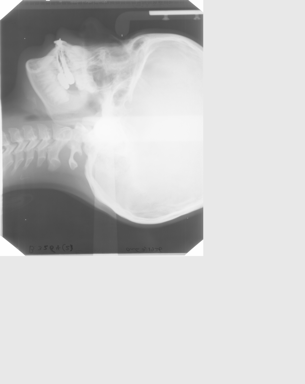

In [4]:
# Open the sample image "scan.png" and resize it to fit on the notebook
img = Image.open("scan.png")
img = img.convert('L')
thumbnail = img.resize(size=(img.width//4,img.height//4))
display(thumbnail)

#### Generate the 1-bit mask
An unknown number of TIFFs from the original BB collection present a large "white-noise" background that should be discarded.  
First, we create a 1-bit mask based on an arbitrary threshold (0-255).  
Every pixel that is above the threshold (brighter) will be white in the mask, while any other pixel will be black.  
The goal is to choose a threshold value low enough to render the background noise entirely white in the mask while still keeping the majority of the pixels black.

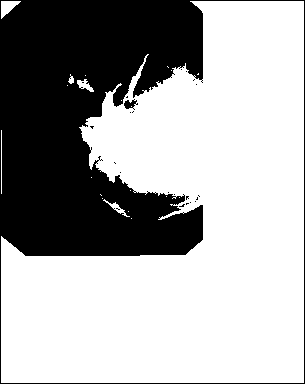

In [5]:
# convert the image to a byte array to do the actual processing with the Numpy module
np_img = np.array(img)

# choose a suitable threshold
mask = np_img > 230

# convert the array back to a Pillow image to display it
mask_img = Image.fromarray(mask)

# resize for notebook and add a border to show the white background is still there
thumbnail = mask_img.resize(size=(mask_img.width//4, mask_img.height//4))
draw = ImageDraw.Draw(thumbnail)
width, height = thumbnail.size
border_width = 1
border_color = 0  # Black
draw.rectangle([(0, 0), (width - 1, height - 1)], outline=border_color, width=border_width)
display(thumbnail)

#### Find the coordinates of the encompassing rectangle
The next step is to determine the x,y coordinates of the top/left and bottom/right angles of the encompassing rectangle.  
The *argwhere* function of the *Numpy* module outputs an array of x,y coordinates of every black pixel in the mask.

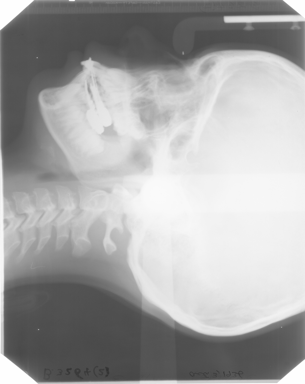

In [6]:
# argwhere selects coordinates of white pixels (1 or True)
# so we need to invert the mask with '~' to get black pixels coordinates
coords = np.argwhere(~mask)

# extract top/left bottom/right rectangle coordinates
x0, y0 = coords.min(axis=0)
x1, y1 = coords.max(axis=0) + 1

# crop the image to the rectangle we just found
np_cropped = np_img[x0:x1, y0:y1]

# convert the array back to a Pillow image, resize and display
cropped_img = Image.fromarray(np_cropped)
thumbnail = cropped_img.resize(size=(mask_img.width//4, mask_img.height//4))
display(thumbnail)

The image is now clean and ready to be used in the training dataset.